<a href="https://colab.research.google.com/github/PAVEL990/AtmCaseStudy1/blob/main/ml_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np

# Some sklearn tools for preprocessing and building a pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# The algorithms used, from the easiest to the hardest to interpret
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [ ]:
# Used for the analysis part
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [10]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=bea46ce85715289962c11c9f68bca44b302195700a6439c9a7883fb554df400a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [11]:
from lime import lime_tabular

In [12]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
from collections import Counter
from functools import partial #custom predict proba section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MLdataset/weatherAUS.csv")

In [ ]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0           W           44.0          W  ...        22.0       1007.7   
1         WNW           44.0        NNW  ...        25.0       1010.6   
2         WSW           46.0          W  ...        30.0       1007.6   
3          NE           24.0         SE  ...        16.0       1017.6   
4           W           41.0        ENE  ...        33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RISK_MM  \
0       1007.1       8.0       NaN     16.9     21.8         No      0.0   
1       1007.8       NaN       NaN     17.2     24.3         No      0.0   
2       1008.7       NaN       2.0     21.0     23.2         No      0.0   
3       1012.8       NaN       NaN     18.1     26.5         No      1.0   
4       1006.0       7.0       8.0     17.8     29.7         No      0.2   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 24 columns]

In [ ]:
df.RainTomorrow.value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [ ]:
# https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas
rs = np.random.RandomState(0)
df2 = pd.DataFrame(rs.rand(24, 24))
corr = df2.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-18-7bdf4fba9924>:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


In [ ]:
# Processing the direction
df["WindGustDir"] = df["WindGustDir"].map({"N":1, "NE":2, "NW":3, "NNE":4, "NNW":5, "E":6, "ENE":7, "ESE":8, "S":9, "SE":10, "SW":11,
"SSE":12, "SSW":13, "W":14, "WNW":15, "WSW":16})
df["WindDir9am"] = df["WindDir9am"].map({"N":1, "NE":2, "NW":3, "NNE":4, "NNW":5, "E":6, "ENE":7, "ESE":8, "S":9, "SE":10, "SW":11,
"SSE":12, "SSW":13, "W":14, "WNW":15, "WSW":16})
df["WindDir3pm"] = df["WindDir3pm"].map({"N":1, "NE":2, "NW":3, "NNE":4, "NNW":5, "E":6, "ENE":7, "ESE":8, "S":9, "SE":10, "SW":11,
"SSE":12, "SSW":13, "W":14, "WNW":15, "WSW":16})

In [ ]:
# Changing categorical variables from string to numeric
df["RainToday"] = df["RainToday"].map({"No":0, "Yes":1})
df["RainTomorrow"] = df["RainTomorrow"].map({"No":0, "Yes":1})

In [ ]:
# Droping all variables that are having too many missing values or that are correlating too strongly
df = df.drop(["Date", "Location", "Evaporation", "Sunshine", "Cloud3pm", "Cloud9am", "RISK_MM"], axis =1)

In [ ]:
# Drop all NaNs
df = df.dropna()

In [ ]:
df.head()

MinTemp  MaxTemp  Rainfall  WindGustDir  WindGustSpeed  WindDir9am  \
0     13.4     22.9       0.6         14.0           44.0        14.0   
1      7.4     25.1       0.0         15.0           44.0         5.0   
2     12.9     25.7       0.0         16.0           46.0        14.0   
3      9.2     28.0       0.0          2.0           24.0        10.0   
4     17.5     32.3       1.0         14.0           41.0         7.0   

   WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0        15.0          20.0          24.0         71.0         22.0   
1        16.0           4.0          22.0         44.0         25.0   
2        16.0          19.0          26.0         38.0         30.0   
3         6.0          11.0           9.0         45.0         16.0   
4         3.0           7.0          20.0         82.0         33.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1007.7       1007.1     16.9     21.8        0.0             0  
1       1010.6       1007.8     17.2     24.3        0.0             0  
2       1007.6       1008.7     21.0     23.2        0.0             0  
3       1017.6       1012.8     18.1     26.5        0.0             0  
4       1010.8       1006.0     17.8     29.7        0.0             0

In [ ]:
rs = np.random.RandomState(0)
df2 = pd.DataFrame(rs.rand(17, 17))
corr = df2.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
df.RainTomorrow.value_counts()

0    87906
1    25019
Name: RainTomorrow, dtype: int64

In [ ]:
## Data Sampling for faster Model Training
#df=df.sample(n=5000,replace="False")
#df.shape

In [ ]:
df.RainTomorrow.value_counts()

0    87906
1    25019
Name: RainTomorrow, dtype: int64

In [ ]:
# Get X, y
y = df["RainTomorrow"]
X = df.drop(["RainTomorrow"], axis =1)
X.head()

MinTemp  MaxTemp  Rainfall  WindGustDir  WindGustSpeed  WindDir9am  \
0     13.4     22.9       0.6         14.0           44.0        14.0   
1      7.4     25.1       0.0         15.0           44.0         5.0   
2     12.9     25.7       0.0         16.0           46.0        14.0   
3      9.2     28.0       0.0          2.0           24.0        10.0   
4     17.5     32.3       1.0         14.0           41.0         7.0   

   WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0        15.0          20.0          24.0         71.0         22.0   
1        16.0           4.0          22.0         44.0         25.0   
2        16.0          19.0          26.0         38.0         30.0   
3         6.0          11.0           9.0         45.0         16.0   
4         3.0           7.0          20.0         82.0         33.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  
0       1007.7       1007.1     16.9     21.8        0.0  
1       1010.6       1007.8     17.2     24.3        0.0  
2       1007.6       1008.7     21.0     23.2        0.0  
3       1017.6       1012.8     18.1     26.5        0.0  
4       1010.8       1006.0     17.8     29.7        0.0

In [ ]:
# Aggregating the features into to variables to build the preprocessor with
num_features = ["MinTemp", "MaxTemp", "WindGustSpeed", "WindSpeed9am",
                "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Pressure9am",
               "Temp9am", "Temp3pm"]

cat_features = ["Rainfall", "WindGustDir", "WindDir9am", "WindDir3pm"]

In [ ]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features),
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

In [ ]:
# The algorithms used, from the easiest to the hardest to interpret
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [ ]:
# Logistic Regression
lr_model = Pipeline([("preprocessor", preprocessor),
                     ("model", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))])

# Decision Tree
dt_model = Pipeline([("preprocessor", preprocessor),
                     ("model", DecisionTreeClassifier(class_weight="balanced"))])

# Random Forest
rf_model = Pipeline([("preprocessor", preprocessor),
                     ("model", RandomForestClassifier(class_weight="balanced", n_estimators=100, n_jobs=-1))])

# XGBoost
xgb_model = Pipeline([("preprocessor", preprocessor),
                      # Add a scale_pos_weight to make it balanced
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

In [ ]:
y_train

6450      1
95680     0
68563     0
95026     0
109994    0
         ..
19401     0
81051     1
102683    1
98442     0
97522     1
Name: RainTomorrow, Length: 79047, dtype: int64

In [ ]:
gs = GridSearchCV(dt_model, {"model__max_depth": [3, 5, 7],
                             "model__min_samples_split": [2, 5]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Temp9am',
                                                                          'Temp3pm']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Rainfall',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm'])])),
                                       ('model',
                                        DecisionTreeClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [3, 5, 7],
                         'model__min_samples_split': [2, 5]},
             scoring='accuracy')

In [ ]:
print(gs.best_params_)
print(gs.best_score_)

{'model__max_depth': 7, 'model__min_samples_split': 2}
0.7828001623907854


In [ ]:
dt_model.set_params(**gs.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['MinTemp', 'MaxTemp',
                                                   'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Temp9am',
                                                   'Temp3pm']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Rainfall', 'WindGustDir',
                                                   'WindDir9am',
                                                   'WindDir3pm'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=7))])

In [ ]:
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
accuracy_score(y_test, y_pred)

0.7941141743904598

In [ ]:
# Decision Tree Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86     26372
           1       0.53      0.73      0.61      7506

    accuracy                           0.79     33878
   macro avg       0.72      0.77      0.74     33878
weighted avg       0.83      0.79      0.80     33878



In [ ]:
# Make probability predictions
train_probs = dt_model.predict_proba(X_train)[:, 1]
probs = dt_model.predict_proba(X_test)[:, 1]

train_predictions = dt_model.predict(X_train)
predictions = dt_model.predict(X_test)

In [ ]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.8595604743255038
Test ROC AUC  Score: 0.8509923417755002


In [ ]:
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Baseline ROC AUC: 0.5


In [ ]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""

    baseline = {}

    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5

    results = {}

    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)

    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)

    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline', linestyle='--')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [ ]:
print(Counter(probs))
print(Counter(predictions))

Counter({0.1487044374497289: 2712, 0.2362625461496908: 2594, 0.03317710227133175: 2045, 0.2735142766149777: 2004, 0.07732997361793648: 1204, 0.04717070331632368: 1143, 0.3820465405220061: 1121, 0.15001499445435743: 884, 0.1230298495621069: 738, 0.3213506419904481: 734, 0.9625654618130507: 707, 0.05382907425749521: 656, 0.6401166597500412: 647, 0.10678093596910398: 611, 0.4426524103797876: 600, 0.4213218644843337: 576, 0.37346885245857603: 570, 0.11468895158882787: 568, 0.38616603067819755: 519, 0.9862001374065162: 510, 0.5152015168860525: 501, 0.7669887863946928: 482, 0.4782416648639943: 441, 0.8300156997433693: 425, 0.8434454107535423: 418, 0.9416515404541556: 357, 0.6571255163772323: 348, 0.5198574983528839: 319, 0.8002504324845527: 305, 0.14844266927644517: 303, 0.9362363881379675: 297, 0.5897249683737036: 293, 0.9605695149267561: 284, 0.3577918982371762: 272, 0.7263986907780183: 262, 0.9147925021164428: 261, 0.3725122291284364: 256, 0.8730540281911462: 254, 0.3591228961789464: 245,

Recall Baseline: 1.0 Test: 0.73 Train: 0.74
Precision Baseline: 0.22 Test: 0.53 Train: 0.53
Roc Baseline: 0.5 Test: 0.85 Train: 0.86


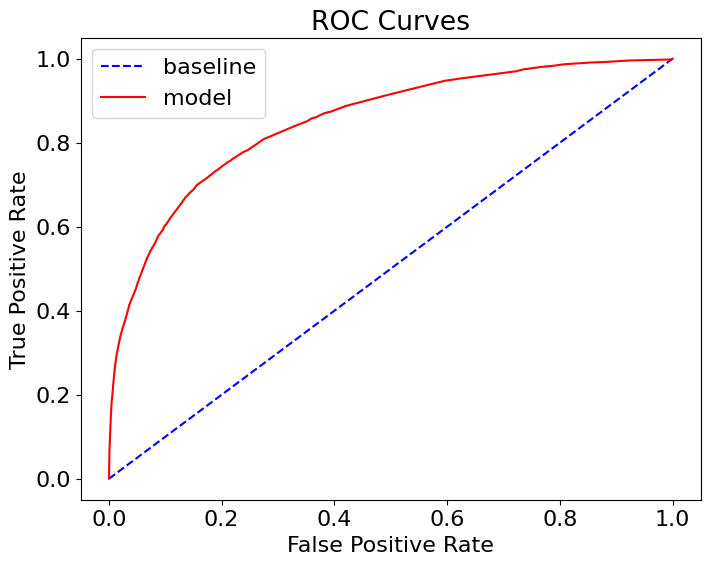

In [ ]:
# Decision Tree ROC Curve
evaluate_model(predictions, probs, train_predictions, train_probs)

In [ ]:
gs = GridSearchCV(lr_model, {"model__C": [1, 1.3, 1.5]}, n_jobs=-1, cv=5, scoring="accuracy")
gs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Temp9am',
                                                                          'Temp3pm']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Rainfall',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm'])])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1, param_grid={'model__C': [1, 1.3, 1.5]},
             scoring='accuracy')

In [ ]:
print(gs.best_params_)
print(gs.best_score_)

{'model__C': 1.5}
0.7900489552924821


In [ ]:
lr_model.set_params(**gs.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['MinTemp', 'MaxTemp',
                                                   'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Temp9am',
                                                   'Temp3pm']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Rainfall', 'WindGustDir',
                                                   'WindDir9am',
                                                   'WindDir3pm'])])),
                ('model',
                 LogisticRegression(C=1.5, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

In [ ]:
lr_model.get_params("model")

NameError: name 'lr_model' is not defined

In [ ]:
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['MinTemp', 'MaxTemp',
                                                   'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Temp9am',
                                                   'Temp3pm']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Rainfall', 'WindGustDir',
                                                   'WindDir9am',
                                                   'WindDir3pm'])])),
                ('model',
                 LogisticRegression(C=1.5, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

In [ ]:
y_pred = lr_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7928449141035481

In [ ]:
# Logistic Regression Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     26372
           1       0.52      0.77      0.62      7506

    accuracy                           0.79     33878
   macro avg       0.72      0.79      0.74     33878
weighted avg       0.84      0.79      0.81     33878



In [ ]:
train_lr_predictions = lr_model.predict(X_train)
train_lr_probs = lr_model.predict_proba(X_train)[:, 1]

lr_predictions = lr_model.predict(X_test)
lr_probs = lr_model.predict_proba(X_test)[:, 1]

Recall Baseline: 1.0 Test: 0.77 Train: 0.77
Precision Baseline: 0.22 Test: 0.52 Train: 0.52
Roc Baseline: 0.5 Test: 0.87 Train: 0.87


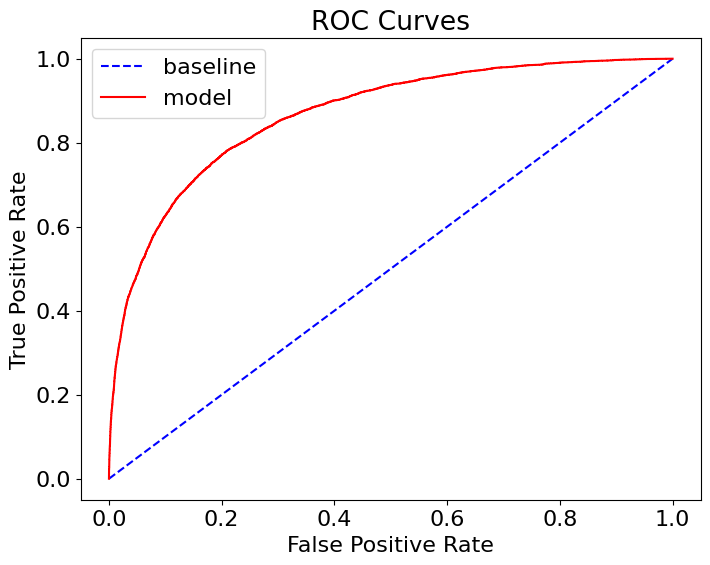

In [ ]:
# Logistic Regression ROC Curve
evaluate_model(lr_predictions, lr_probs, train_lr_predictions, train_lr_probs)

In [ ]:
preprocessor = lr_model.named_steps["preprocessor"]

In [ ]:
ohe_categories = preprocessor.named_transformers_["categorical"].categories_

In [ ]:
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]

In [ ]:
all_features = num_features + new_ohe_features

In [ ]:
pd.DataFrame(lr_model.named_steps["preprocessor"].transform(X_train), columns=all_features).head()

MinTemp  MaxTemp  WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  \
0     12.1     18.6           31.0          11.0          17.0         84.0   
1     13.8     26.0           39.0          15.0          20.0         52.0   
2      9.9     28.2           31.0          11.0          13.0         46.0   
3     19.2     23.4           41.0          11.0          19.0         63.0   
4     12.6     30.9           43.0          17.0          26.0         42.0   

   Humidity3pm  Pressure9am  Temp9am  Temp3pm  ...  WindDir3pm__7.0  \
0         57.0       1017.5     14.3     17.6  ...              0.0   
1         41.0       1022.1     17.4     23.0  ...              0.0   
2         23.0       1017.1     15.7     24.0  ...              0.0   
3         59.0       1013.1     21.3     20.8  ...              0.0   
4         34.0       1018.5     24.1     28.0  ...              0.0   

   WindDir3pm__8.0  WindDir3pm__9.0  WindDir3pm__10.0  WindDir3pm__11.0  \
0              0.0              0.0               0.0               0.0   
1              0.0              0.0               0.0               1.0   
2              0.0              0.0               0.0               0.0   
3              0.0              0.0               0.0               0.0   
4              0.0              1.0               0.0               0.0   

   WindDir3pm__12.0  WindDir3pm__13.0  WindDir3pm__14.0  WindDir3pm__15.0  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               1.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   WindDir3pm__16.0  
0               0.0  
1               0.0  
2               1.0  
3               0.0  
4               0.0  

[5 rows x 618 columns]

In [ ]:
i = 4
X_test.iloc[[i]]

MinTemp  MaxTemp  Rainfall  WindGustDir  WindGustSpeed  WindDir9am  \
71059     14.2     23.7       0.0         11.0           43.0        13.0   

       WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
71059        11.0          11.0          19.0         66.0         34.0   

       Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  
71059       1014.1       1013.2     15.6     21.3        0.0

In [ ]:

y_test.iloc[i]

0

In [ ]:
gs = GridSearchCV(rf_model, {"model__max_depth": [10, 15],
                             "model__min_samples_split": [5, 10]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Temp9am',
                                                                          'Temp3pm']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Rainfall',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 15],
                         'model__min_samples_split': [5, 10]},
             scoring='accuracy')

In [ ]:
print(gs.best_params_)
print(gs.best_score_)

{'model__max_depth': 15, 'model__min_samples_split': 5}
0.7987273440388503


In [ ]:
rf_model.set_params(**gs.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['MinTemp', 'MaxTemp',
                                                   'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Temp9am',
                                                   'Temp3pm']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Rainfall', 'WindGustDir',
                                                   'WindDir9am',
                                                   'WindDir3pm'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=5, n_jobs=-1))])

In [ ]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
accuracy_score(y_test, y_pred)

0.7968002833697385

In [ ]:
# Random Forest Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86     26372
           1       0.53      0.75      0.62      7506

    accuracy                           0.80     33878
   macro avg       0.72      0.78      0.74     33878
weighted avg       0.83      0.80      0.81     33878



In [ ]:
train_rf_predictions = rf_model.predict(X_train)
train_rf_probs = rf_model.predict_proba(X_train)[:, 1]

rf_predictions = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

Recall Baseline: 1.0 Test: 0.75 Train: 0.79
Precision Baseline: 0.22 Test: 0.53 Train: 0.56
Roc Baseline: 0.5 Test: 0.86 Train: 0.89


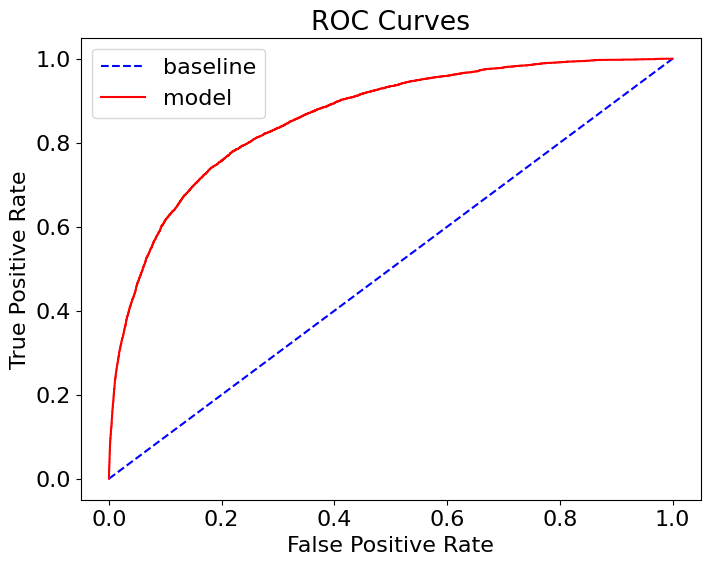

In [ ]:
# Random Forest ROC Curve
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [ ]:
gs = GridSearchCV(xgb_model, {"model__max_depth": [5, 10],
                              "model__min_child_weight": [5, 10],
                              "model__n_estimators": [25]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Temp9am',
                                                                          'Temp3pm']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Rainfall',
                                                                          'WindGustDir',
                                                                          'WindDi...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 10],
                         'model__min_child_weight': [5, 10],
                         'model__n_estimators': [25]},
             scoring='accuracy')

In [ ]:
print(gs.best_params_)
print(gs.best_score_)
xgb_model.set_params(**gs.best_params_)
xgb_model.fit(X_train, y_train)

{'model__max_depth': 10, 'model__min_child_weight': 10, 'model__n_estimators': 25}
0.8507849438759955


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['MinTemp', 'MaxTemp',
                                                   'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Temp9am',
                                                   'Temp3pm']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Rainfall', 'WindGustDir',
                                                   'WindDir9am',
                                                   'WindDir3pm'])])),
                ('mo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=25, n_jobs=-1,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8532085719345888

In [ ]:
# XG Boost Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     26372
           1       0.77      0.49      0.60      7506

    accuracy                           0.85     33878
   macro avg       0.82      0.72      0.75     33878
weighted avg       0.84      0.85      0.84     33878



In [ ]:
train_xgb_predictions = xgb_model.predict(X_train)
train_xgb_probs = xgb_model.predict_proba(X_train)[:, 1]

xgb_predictions = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

Recall Baseline: 1.0 Test: 0.49 Train: 0.55
Precision Baseline: 0.22 Test: 0.77 Train: 0.85
Roc Baseline: 0.5 Test: 0.88 Train: 0.92


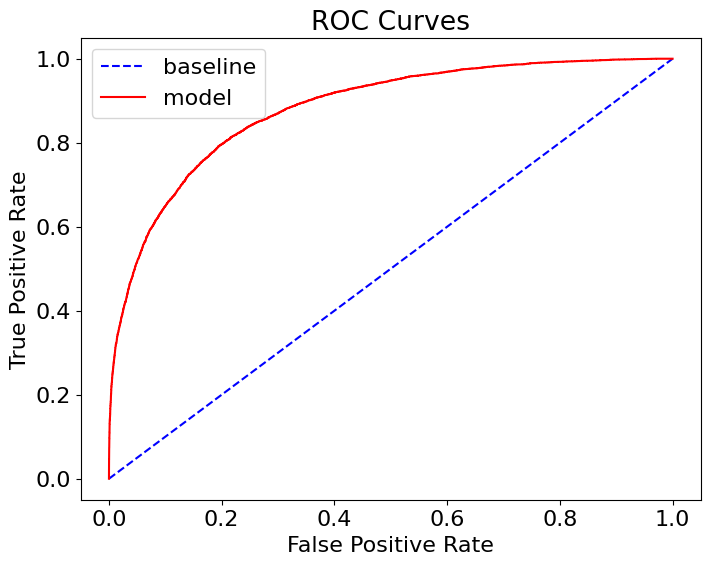

In [ ]:
# XG Boost ROC Curve
evaluate_model(xgb_predictions, xgb_probs, train_xgb_predictions, train_xgb_probs)

In [ ]:
## Changed that from the original
categorical_names = {}

# List of all possible values per feature
cat_values = preprocessor.named_transformers_["categorical"].categories_

for col, val in zip(cat_features, cat_values):

    categorical_names[df.columns.get_loc(col)] = list(val)

In [ ]:
## Because the original Line wasn't working, I did this instead
## I found it here: https://github.com/klemag/PyconUS_2019-model-interpretability-tutorial/blob/master/helpers.py

def convert_to_lime_format(X, categorical_names, col_names=None, invert=False):
    """Converts data with categorical values as string into the right format
    for LIME, with categorical values as integers labels.
    It takes categorical_names, the same dictionary that has to be passed
    to LIME to ensure consistency.
    col_names and invert allow to rebuild the original dataFrame from
    a numpy array in LIME format to be passed to a Pipeline or sklearn
    OneHotEncoder
    """

    # If the data isn't a dataframe, we need to be able to build it
    if not isinstance(X, pd.DataFrame):
        X_lime = pd.DataFrame(X, columns=col_names)
    else:
        X_lime = X.copy()

    for k, v in categorical_names.items():
        if not invert:
            label_map = {
                str_label: int_label for int_label, str_label in enumerate(v)
            }

        else:
            label_map = {
                int_label: str_label for int_label, str_label in enumerate(v)
            }

        X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)

    return X_lime

In [ ]:
convert_to_lime_format(X_train, categorical_names).head()

<ipython-input-84-bf7fb71f7329>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
<ipython-input-84-bf7fb71f7329>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
<ipython-input-84-bf7fb71f7329>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uni

MinTemp  MaxTemp  Rainfall  WindGustDir  WindGustSpeed  WindDir9am  \
6450       12.1     18.6         0            3           31.0           1   
95680      13.8     26.0         0           13           39.0          11   
68563       9.9     28.2         0           12           31.0          11   
95026      19.2     23.4         0           10           41.0          10   
109994     12.6     30.9         0           11           43.0           5   

        WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
6450             1          11.0          17.0         84.0         57.0   
95680           10          15.0          20.0         52.0         41.0   
68563           15          11.0          13.0         46.0         23.0   
95026           11          11.0          19.0         63.0         59.0   
109994           8          17.0          26.0         42.0         34.0   

        Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  
6450         1017.5       1012.2     14.3     17.6        0.0  
95680        1022.1       1019.5     17.4     23.0        0.0  
68563        1017.1       1014.2     15.7     24.0        0.0  
95026        1013.1       1012.9     21.3     20.8        0.0  
109994       1018.5       1015.7     24.1     28.0        0.0

In [ ]:
explainer = LimeTabularExplainer(convert_to_lime_format(X_train, categorical_names).values,
                                 mode="classification",
                                 feature_names=X_train.columns.tolist(),
                                 categorical_names=categorical_names,
                                 categorical_features=categorical_names.keys(),
                                 discretize_continuous=True,
                                 random_state=42)

<ipython-input-84-bf7fb71f7329>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
<ipython-input-84-bf7fb71f7329>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
<ipython-input-84-bf7fb71f7329>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uni

In [ ]:
i = 300
X_observation = X_test.iloc[[i], :]
X_observation

MinTemp  MaxTemp  Rainfall  WindGustDir  WindGustSpeed  WindDir9am  \
11836     14.8     21.1       1.8         16.0           26.0        16.0   

       WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
11836        16.0          13.0           9.0         77.0         70.0   

       Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  
11836       1024.7       1022.2     19.0     20.6        1.0

In [ ]:
print(f"""\
* True label: {y_test.iloc[i]}
* LR: {lr_model.predict_proba(X_observation)[0]}
* DT: {dt_model.predict_proba(X_observation)[0]}
* RF: {rf_model.predict_proba(X_observation)[0]}
* XGB: {xgb_model.predict_proba(X_observation)[0]}""")

* True label: 1
* LR: [0.44010096 0.55989904]
* DT: [0.35988334 0.64011666]
* RF: [0.40485215 0.59514785]
* XGB: [0.7912098  0.20879018]


In [ ]:
observation = convert_to_lime_format(X_test.iloc[[i], :],categorical_names).values[0]
observation

<ipython-input-84-bf7fb71f7329>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
<ipython-input-84-bf7fb71f7329>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
<ipython-input-84-bf7fb71f7329>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uni

array([1.4800e+01, 2.1100e+01, 1.8000e+01, 1.5000e+01, 2.6000e+01,
       1.5000e+01, 1.5000e+01, 1.3000e+01, 9.0000e+00, 7.7000e+01,
       7.0000e+01, 1.0247e+03, 1.0222e+03, 1.9000e+01, 2.0600e+01,
       1.0000e+00])

In [ ]:
# Lets write a custom predict_proba functions for our models:
from functools import partial

def custom_predict_proba(X, model):
    X_str = convert_to_lime_format(X, categorical_names, col_names=X_train.columns, invert=True)
    return model.predict_proba(X_str)

lr_predict_proba = partial(custom_predict_proba, model=lr_model)
dt_predict_proba = partial(custom_predict_proba, model=dt_model)
rf_predict_proba = partial(custom_predict_proba, model=rf_model)
xgb_predict_proba = partial(custom_predict_proba, model=xgb_model)

In [ ]:
# Log Reg Explainer

explanation = explainer.explain_instance(observation, lr_predict_proba, num_features=5)

In [ ]:
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.5291534834953349


In [ ]:
explanation.save_to_file("explanation.html")

In [ ]:
print(explanation.local_exp)
print(explanation.intercept)
print(explanation.score)

{1: [(10, 0.4376827829719741), (4, -0.2281634855295169), (8, 0.09546136978927061), (11, -0.037527916811319735), (6, -0.024941089671718465)]}
{1: 0.35182907698437804}
0.5291534834953349


In [ ]:
# DT Explainer

explanation = explainer.explain_instance(observation, dt_predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.4714221703878513


In [ ]:
# RF Explainer

explanation = explainer.explain_instance(observation, rf_predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.47933483601390137


In [ ]:
# XGB Explainer

explanation = explainer.explain_instance(observation, xgb_predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.4504343757506153
